# Board Game Ranking: Exploratory Data Analysis

## Context: 

Board games have long been a part of human culture with the historical records dating back as early as 2000 B.C.<sup>1</sup> In recent years, board games have experienced a resurgence in popularity. Tabletop gaming is now a burgeoning industry which had an estimated market of approximately 7.2 billion USD in 2017 and is expected to increase by 4.8 billion USD by 2023<sup>2</sup>. The US card and board game market alone is predicted to increase to 5 billion USD by 2025<sup>3</sup>. Understanding what makes a game popular is important for game developers to determine what kinds of games they should focus on producing.

I've scraped ranking data from [BoardGameGeek.com](https://www.boardgamegeek.com/browse/boardgame) for 19,019 games which will be used in this analysis. As indicated in its name, BoardGameGeek is not just a database of board games and ratings, but is a place for everything board game related. The site has forums to discuss games and rules, resources such as translations and player aids, and even a board game aftermarket. This data is current as of 6/12/20.

<sup>1</sup> https://www.newyorker.com/culture/culture-desk/what-we-learn-from-one-of-the-worlds-oldest-board-games

<sup>2</sup> https://en.wikipedia.org/wiki/Tabletop_game_industry

<sup>3</sup> https://www.statista.com/statistics/1072762/us-card-and-board-games-market-value/

In [1]:
# import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from IPython.display import Image
%matplotlib inline

bgg = pd.read_csv('bgg_clean_impute.csv', index_col=0)
pd.set_option('max_colwidth', 120)

# KNN was used to impute missing values. I'm rounding these columns to remove inconsistencies with age which 
# is recorded as a whole number as well as with player count which must be a whole number
bgg.age = bgg.age.round()
bgg.min_players = bgg.min_players.round()
bgg.max_players = bgg.max_players.round()

In [2]:
# descriptive statistics of the data set
bgg.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,19019.0,6.386327,0.926332,1.050,5.800,6.420,7.000,9.690
geek_rating,19019.0,5.690209,0.370863,3.537,5.511,5.551,5.689,8.573
num_voters,19019.0,813.651349,3331.557546,30.000,55.000,120.000,379.500,94727.000
rank,19019.0,9511.235817,5491.270778,1.000,4755.500,9512.000,14266.500,19021.000
game_id,19019.0,99563.504969,93033.632027,1.000,9856.500,69105.000,180423.000,310100.000
age,19019.0,10.242337,2.710194,1.000,8.000,10.000,12.000,25.000
max_play_time,19019.0,99.528366,1033.539496,1.000,30.000,45.000,90.000,120000.000
max_players,19019.0,5.549293,9.087904,1.000,4.000,4.000,6.000,362.000
min_play_time,19019.0,68.703549,476.215933,1.000,20.000,30.000,60.000,60000.000
min_players,19019.0,2.036490,0.674595,1.000,2.000,2.000,2.000,10.000


In [3]:
bgg.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/gloomhaven/credits,1,174430,"'Adventure', 'Exploration', 'Fantasy', 'Fighting', 'Miniatures'","'Action Retrieval', 'Campaign / Battle Card Driven', 'Communication Limits', 'Cooperative Game', 'Deck, Bag, and Poo...","'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Gloomhaven', 'Mechanic: Campaign Ga...",12.0,120.0,4.0,60.0,1.0,3.832
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1/credits,2,161936,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Management', 'Legacy Game', 'Point to Point Movement', 'Set Collection', ...","'Game: Pandemic', 'Mechanic: Campaign Games', 'Mechanic: Legacy', 'Medical: Diseases'",13.0,60.0,4.0,60.0,2.0,2.830
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/brass-birmingham/credits,3,224517,"'Economic', 'Industry / Manufacturing', 'Transportation'","'Connections', 'Hand Management', 'Income', 'Loans', 'Market', 'Network and Route Building', 'Tech Trees / Tech Trac...","'Cities: Birmingham (England)', 'Country: England', 'Crowdfunding: Kickstarter', 'Game: Brass', 'History: Industrial...",14.0,120.0,4.0,60.0,2.0,3.930
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/terraforming-mars/credits,4,167791,"'Economic', 'Environmental', 'Industry / Manufacturing', 'Science Fiction', 'Space Exploration', 'Territory Building'","'Card Drafting', 'End Game Bonuses', 'Hand Management', 'Hexagon Grid', 'Income', 'Set Collection', 'Solo / Solitair...","'Game: Terraforming Mars', 'Mechanic: Tableau Building', 'Players: Games with Solitaire Rules', 'Series: Future Time...",12.0,120.0,5.0,120.0,1.0,3.236
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/through-ages-new-story-civilization/credits,5,182028,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: Dutch', 'Card Drafting', 'Income'","'Game: Through the Ages', 'Mechanic: Tableau Building'",14.0,120.0,4.0,120.0,2.0,4.395


### Description of Attributes:

- avg_rating: aggregated ranking of user ratings (1-10)
- geek_rating: BoardGameGeek's proprietary ranking system which uses a weighted avg rating used to determine a game's rank (1-10) 
 - games must have a minimum of 30 user ratings to have a Geek Rating
 - games without a Geek Rating are not included in this data set
- num_voters: number of users who have rated a game
- title: the name of the game
- full_game_url: game page
- rank: absolute ranking of a game based on Geek Rating
- game_id: unique identifier
- category: a classification for the thematic type of board game
- mechanic: an element or type of gameplay
- family: an attempt to group a game into a broader set of descriptors
- age*: recommened minimum age to play the game
- max_play_time*: the maximum time the game is estimated to complete
- max_players*: maximum number of players the game can support
- min_play_time*: the minimum time the game is estimated to complete
- min_players*: minimum number of players the game can support
- weight: an aggregated measure of complexity as reported by users (1-5)
 
*publisher provided values

## Numerical Attribute Exploration

### Geek Rating

I first want to investigate the distribution of ratings. Geek Rating is what determines a game's placement on the Geek Charts (the scraped pages) and this is based on an altered average rating. As found in the [FAQ](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ), Bayesian averaging is used to prevent games with few votes from skewing the data. The exact algorithm is unknown, but it is believed by the community that every game receives approximately 100 dummy votes with a 5.5 value.

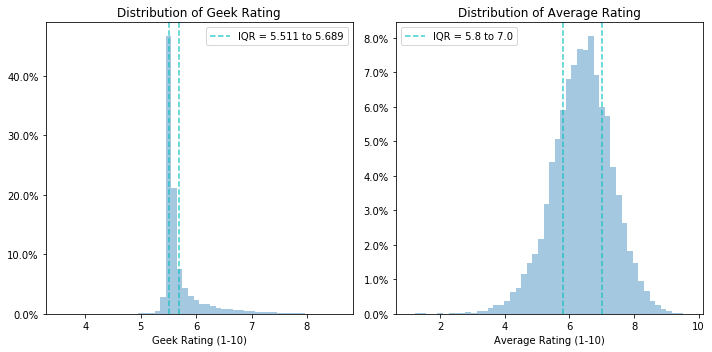

In [4]:
_ = plt.subplots(figsize=(10,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(bgg.geek_rating, hist_kws={'weights': (np.ones(len(bgg.geek_rating)) / len(bgg.geek_rating))}, kde=False)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.25), label='IQR = 5.511 to 5.689', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Geek Rating (1-10)')
_ = plt.title('Distribution of Geek Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

_ = plt.subplot(1,2,2)
_ = sns.distplot(bgg.avg_rating, hist_kws={'weights': (np.ones(len(bgg.avg_rating)) / len(bgg.avg_rating))}, kde=False)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.25), label='IQR = 5.8 to 7.0', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Average Rating (1-10)')
_ = plt.title('Distribution of Average Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()

The left chart shows the distribution of the Geek Rating. In terms of "all-stars" There are 14 games with a Geek Rating > 8 (0.00736% of games), and 374 with a Geek Rating > 7 (1.966% of games). Additionally, we can clearly see the Bayesian averaging in effect with the majority of games having a score between 5 and 6 as well as an incredible right skew.

In comparison, avg rating, representing raw user rating in the right chart, shows more distribution among values. Avg rating does not show the same skew and peaks around a rating of 7. This tells us that users tend to rate games positively (>5).

### Correlation Heatmap

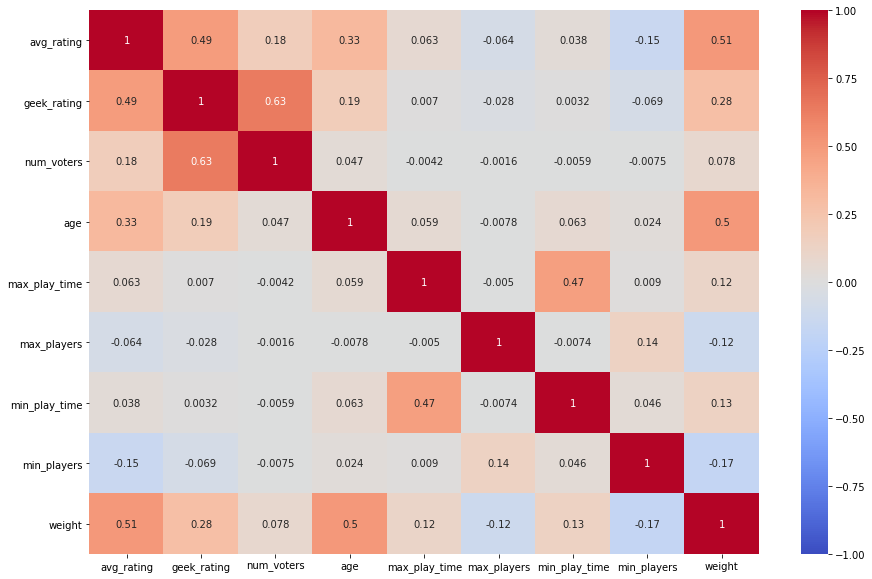

In [5]:
corr = bgg.drop(columns=['rank','game_id']).corr()
fig = plt.subplots(figsize=(15,10))
ax =  sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

This chart shows the correlation between variables. We can see that the number of votes shows the highest correlation with Geek Rating (as opposed to avg rating which was expected). In essence, the Bayesian averaging represents a hurdle to overcome and a game needs to be popular by avg rating before it can have a good Geek Rating.

There are also correlations between age and weight and max play time and min play time.

We should look further at the number of voters, age, and weight metrics and their relationships with both Geek Rating and avg rating.

### Number of Votes

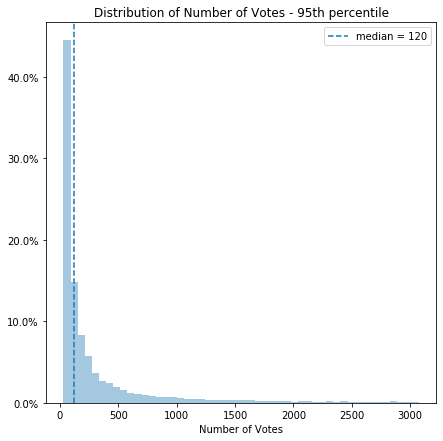

In [6]:
# filtering to only plot the 95th percentile for visualization purposes
bgg_votes = bgg[['num_voters']]
p95 = bgg_votes.quantile(0.95)
bgg_votes95 = bgg_votes[(bgg_votes < p95).any(axis=1)]

_ = plt.figure(figsize=(7,7))
_ = sns.distplot(bgg_votes95, kde=False, hist_kws={'weights' : (np.ones(len(bgg_votes95)) / len(bgg_votes95))})
_ = plt.axvline(x=bgg.num_voters.median(), label='median = 120', linestyle='--')
_ = plt.xlabel('Number of Votes')
_ = plt.title('Distribution of Number of Votes - 95th percentile')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

This shows the distribution of the volume of votes across games. It is important to note that the number of votes includes significant outliers. Incredibly popular games receive a high volume of votes while the average is much lower, so I've only plotted the 95th percentile. While the max number of votes for a game is 94,727, the median is 120. This helps explain why the Geek Rating rarely deviates from the 5.5 range.

### Weight

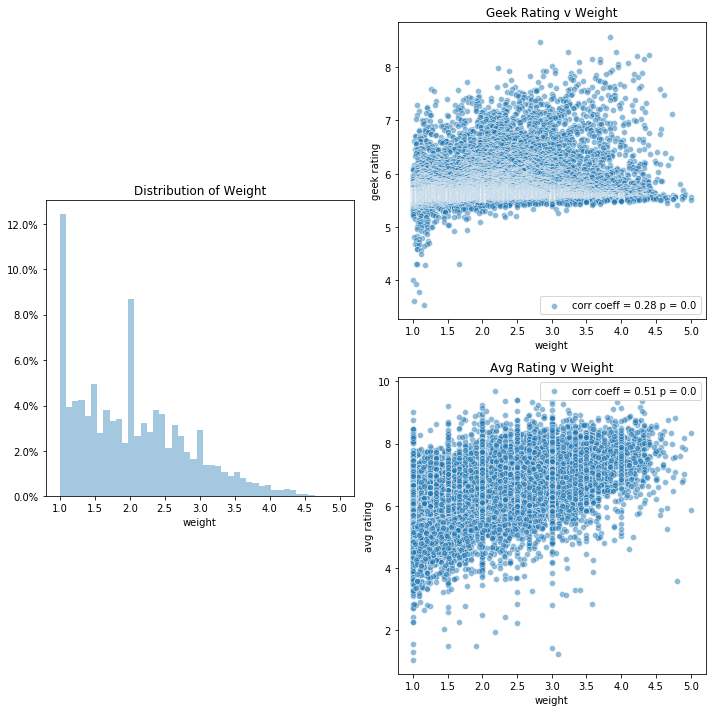

In [7]:
geek_v_weight_coef, geek_v_weight_p = stats.pearsonr(bgg.weight, bgg.geek_rating)
avg_v_weight_coef, avg_v_weight_p = stats.pearsonr(bgg.weight, bgg.avg_rating)


fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(8, 2)

ax = fig.add_subplot(gs[2:6, 0])
_ = sns.distplot(bgg.weight, kde=False, hist_kws={'weights' : (np.ones(len(bgg.weight)) / len(bgg.weight))})
_ = plt.title('Distribution of Weight')
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax = fig.add_subplot(gs[0:4, 1])
_ = sns.scatterplot(x='weight', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_weight_coef,2)) + ' p = ' + str(geek_v_weight_p)))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Weight')

ax = fig.add_subplot(gs[4:8, 1])
_ = sns.scatterplot(x='weight', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Weight')

Here I show the distribution of weight and plot it against Geek Rating and avg rating. Weight is a user generated number between 1 and 5 representing the complexity of a game. As this is an average, it is biased towards whole and half numbers (e.g. 2.0 or 3.5) due to the volume of games with minimal number of user values recorded. The mean of weight is 2.04 and 75% of all games are below 2.56. While it becomes more sparse at the higher end of weight, we can see a positive correlation between weight and Geek Rating.

### Age

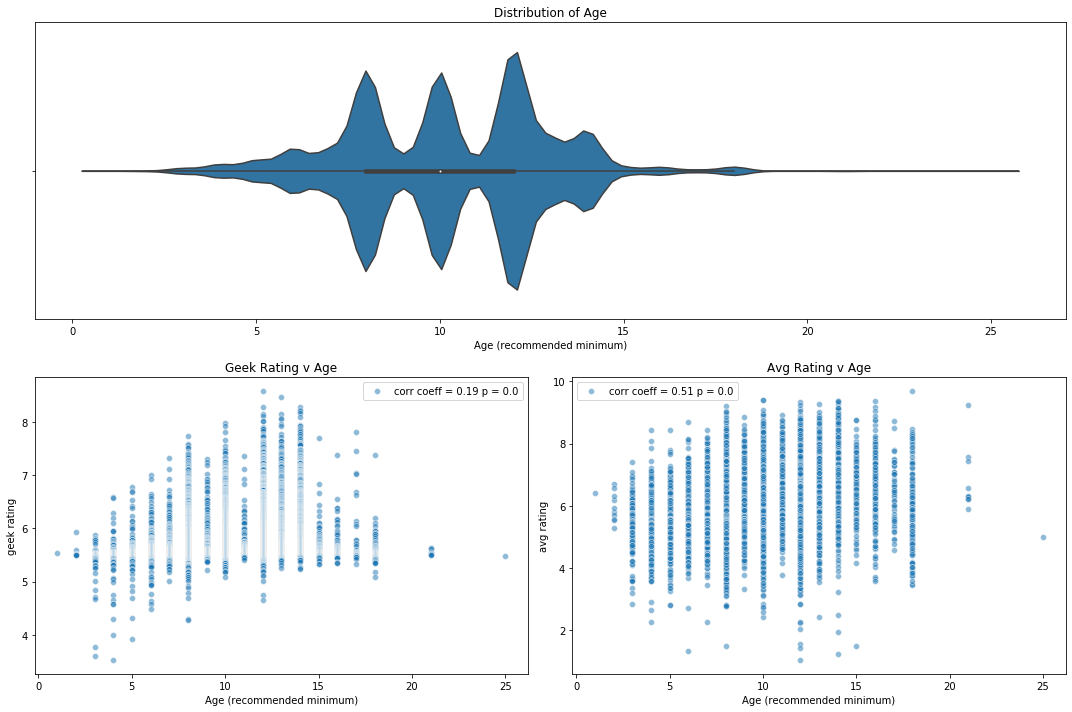

In [8]:
geek_v_age_coef, geek_v_age_p = stats.pearsonr(bgg.age, bgg.geek_rating)
avg_v_age_coef, avg_v_age_p = stats.pearsonr(bgg.age, bgg.avg_rating)

fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,:])
_ = sns.violinplot('age', data=bgg)
_ = plt.title('Distribution of Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Age_Distribution.png')

ax = fig.add_subplot(gs[1,0])
_ = sns.scatterplot(x='age', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_age_coef,2)) + ' p = ' + str(round(geek_v_age_p,2))))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Geek_Rating_v_Age.png')


ax = fig.add_subplot(gs[1,1])
_ = sns.scatterplot(x='age', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Avg_Rating_v_Weight.png')

Mean age is 10, but there are also distribution spikes around 8 and 12-13. Due to age being a discrete variable it is difficult to visualize, but there is correlation with Geek Rating.

## Label Analysis

The scraped data also includes classifications for each game: Category, Mechanic, and Family. As outlined above:

 - Category is a classification for the thematic type of board game e.g. fantasy or children's game. (There are 83 categories.)
 - Mechanic is an element or type of gameplay. Examples include dice rolling, role play, and trading. (There are 186 mechanics.)
 - Family attempts to group a game into a broader set of descriptors. There is a large variety in family including items such as Ancient: Greece, Crowdfunding: Kickstarter, and Video Game Theme: Pokémon. (There are 2,748 families.)


Each game can be assigned multiple categories, mechanics and families. The lists of category, mechanic and family can be found in these links:
 - https://boardgamegeek.com/browse/boardgamecategory
 - https://boardgamegeek.com/browse/boardgamemechanic
 - https://boardgamegeek.com/browse/boardgamefamily


In [9]:
# creating new dataframes for each label type and geek rating
cat = bgg[['geek_rating']]
csplit = bgg.category.str.split(', ', expand=True)
cat = cat.merge(csplit, left_index=True, right_index=True)

# three mechanics have commas which need to be removed before splitting the string 
bgg['mechanic'] = bgg['mechanic'].str.replace('Deck, Bag, and Pool Building', 'Deck Bag and Pool Building')
bgg['mechanic'] = bgg['mechanic'].str.replace('I Cut, You Choose', 'I Cut You Choose')
bgg['mechanic'] = bgg['mechanic'].str.replace('Worker Placement, Different Worker Types', 'Worker Placement Different Worker Types')
mech = bgg[['geek_rating']]
msplit = bgg.mechanic.str.split(', ', expand=True)
mech = mech.merge(msplit, left_index=True, right_index=True)

fam = bgg[['geek_rating']]
fsplit = bgg.family.str.split(', ', expand=True)
fam = fam.merge(fsplit, left_index=True, right_index=True)

# melting dataframes so that its tidy
cat = cat.melt(id_vars=['geek_rating'], value_name='category').drop(columns='variable').dropna()
mech = mech.melt(id_vars=['geek_rating'], value_name='mechanic').drop(columns='variable').dropna()
fam = fam.melt(id_vars=['geek_rating'], value_name='family').drop(columns='variable').dropna()

# grouping by classification and aggregating by count and mean of geek rating
cat_group = cat.groupby(cat.category).geek_rating.agg(['count','mean'])
cat_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)
fam_group = fam.groupby(fam.family).geek_rating.agg(['count','mean'])
fam_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)
mech_group = mech.groupby(mech.mechanic).geek_rating.agg(['count','mean'])
mech_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)

### Category

In [10]:
cat_group.sort_values(by='mean_geek_rating', ascending=False).tail(5)

,count,mean_geek_rating
category,,
'Math',129,5.568543
'Electronic',188,5.566516
'Memory',477,5.552136
"""Children's Game""",1427,5.529584
'Trivia',515,5.528363


These are the the 5 worst rated categories with [Trivia](https://boardgamegeek.com/boardgamecategory/1027/trivia) in last place. In particular, the [Children's Games](https://boardgamegeek.com/boardgamecategory/1041/childrens-game) category being a low rating category aligns with the correlation between rating and age. For fun, let's look at the 10 worst games in the data set:

In [11]:
bgg[['title','category','geek_rating','age','weight']].tail(10)

,title,category,geek_rating,age,weight
19009,Operation,"'Action / Dexterity', ""Children's Game"", 'Medical'",4.486,6.0,1.115
19010,LCR,'Dice',4.311,5.0,1.050
19011,Monopoly,"'Economic', 'Negotiation'",4.299,8.0,1.659
19012,Trouble,"""Children's Game"", 'Racing'",4.298,4.0,1.056
19013,The Game of Life,"""Children's Game"", 'Economic'",4.281,8.0,1.177
19014,War,"'Card Game', ""Children's Game""",4.004,4.0,1.000
19015,Bingo,"'Movies / TV / Radio theme', 'Number', 'Party Game'",3.926,5.0,1.048
19016,Candy Land,"""Children's Game"", 'Racing'",3.779,3.0,1.082
19017,Chutes and Ladders,"'Animals', ""Children's Game"", 'Dice', 'Movies / TV / Radio theme'",3.611,3.0,1.021
19018,Tic-Tac-Toe,"'Abstract Strategy', ""Children's Game""",3.537,4.0,1.154


7 of the 10 worst games are in the [Children's Games](https://boardgamegeek.com/boardgamecategory/1041/childrens-game) category except [Bingo](https://boardgamegeek.com/boardgame/7316/bingo), [Monopoly](https://boardgamegeek.com/boardgame/1406/monopoly), and [LCR](https://boardgamegeek.com/boardgame/3522/lcr) (a game that is only about 'winning' dice rolls). We can also see that the weight of these games are around 1, aside from Monopoly, which still only reaches a weight of 1.659. The majority of these games are determined purely by chance and involve little to no decision making.

A standout category however is [Abstract Strategy](https://boardgamegeek.com/boardgamecategory/1009/abstract-strategy) under [Tic-Tac-Toe](https://boardgamegeek.com/boardgame/11901/tic-tac-toe). BoardGameGeek defines Abstract Strategy as:
- theme-less (without storyline)
- built on simple and/or straightforward design and mechanics
- perfect information games
- games that promote one player overtaking their opponent(s)
- little to no elements of luck, chance, or random occurrence

As a category this fits Tic-Tac-Toe, but there are only a handful of moves a player can take. Conversly, this category also includes games such as [Chess](https://boardgamegeek.com/boardgame/171/chess) (6.9 Geek Rating/3.71 weight) and [Go](https://boardgamegeek.com/boardgame/188/go) (7.0 Geek Rating/3.99 weight) both of which have sophisticated strategies to them.

In [12]:
cat_group.sort_values(by='mean_geek_rating', ascending=False).head(5)

,count,mean_geek_rating
category,,
'Civilization',310,6.047019
'City Building',473,5.993662
'Industry / Manufacturing',260,5.978542
'Renaissance',238,5.953256
'Farming',213,5.931338


And these are the 5 top rated categories. Notably, [Farming](https://boardgamegeek.com/boardgamecategory/1013/farming), [Industry/Manufacturing](https://boardgamegeek.com/boardgamecategory/1088/industry-manufacturing), [City Building](https://boardgamegeek.com/boardgamecategory/1029/city-building), and [Civilization](https://boardgamegeek.com/boardgamecategory/1015/civilization) are all different flavors of a game mechanic commonly known as [Resource Management](https://en.wikipedia.org/wiki/Game_mechanics#Resource_management). Game resources are defined as including "tokens, money, land, natural resources, human resources and game points... The game will have rules that determine how players can increase, spend, or exchange their various resources. The skillful management of resources under such rules allows players to influence the outcome of the game." 

In [13]:
bgg[['title','category','geek_rating','age','weight']].head(10)

,title,category,geek_rating,age,weight
0,Gloomhaven,"'Adventure', 'Exploration', 'Fantasy', 'Fighting', 'Miniatures'",8.573,12.0,3.832
1,Pandemic Legacy: Season 1,"'Environmental', 'Medical'",8.472,13.0,2.830
2,Brass: Birmingham,"'Economic', 'Industry / Manufacturing', 'Transportation'",8.279,14.0,3.930
3,Terraforming Mars,"'Economic', 'Environmental', 'Industry / Manufacturing', 'Science Fiction', 'Space Exploration', 'Territory Building'",8.277,12.0,3.236
4,Through the Ages: A New Story of Civilization,"'Card Game', 'Civilization', 'Economic'",8.219,14.0,4.395
5,Twilight Imperium (Fourth Edition),"'Civilization', 'Economic', 'Negotiation', 'Political', 'Science Fiction', 'Space Exploration', 'Wargame'",8.206,14.0,4.220
6,Star Wars: Rebellion,"'Civil War', 'Fighting', 'Miniatures', 'Movies / TV / Radio theme', 'Science Fiction', 'Wargame'",8.158,14.0,3.701
7,Gaia Project,"'Civilization', 'Economic', 'Science Fiction', 'Space Exploration', 'Territory Building'",8.153,12.0,4.332
8,Twilight Struggle,"'Modern Warfare', 'Political', 'Wargame'",8.151,13.0,3.576
9,Great Western Trail,"'American West', 'Animals'",8.104,12.0,3.700


Comparatively, we don't see the same consistency with the top 10 rated games as we did with the worst rated games and the Children's Game category. Half of the top rated games, [Gloomhaven](https://boardgamegeek.com/boardgame/174430/gloomhaven), [Pandemic Legacy: Season 1](https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1), [Star Wars: Rebellion](https://boardgamegeek.com/boardgame/187645/star-wars-rebellion), [Twilight Struggle](https://boardgamegeek.com/boardgame/12333/twilight-struggle), and [Great Western Trail](https://boardgamegeek.com/boardgame/193738/great-western-trail), do not fall into the 5 top rated categories.

There are very high and very low rated games across the examined categories, so the takeaway is "not children's games bad, resource management good," but more so the importance of player agency. Games determined by dice rolls or random chance are generally not well received, but games that allow strategy and player choice are. 

A perfect example of this is [Scythe](https://boardgamegeek.com/boardgame/169786/scythe), the 11th highest ranked game, which is is an "engine-building game set in an alternate-history 1920s period... Players conquer territory, enlist new recruits, reap resources, gain villagers, build structures, and activate monstrous mechs... Scythe gives players almost complete control over their fate". This was then adapted into a children's game, [My Little Scythe](https://boardgamegeek.com/boardgame/226320/my-little-scythe), which is [My Little Pony](https://en.wikipedia.org/wiki/My_Little_Pony) themed and ranks at a respectable 641, where "players take turns choosing to Move, Seek, or Make. These actions will allow players to increase their friendship and pies, power up their actions, complete quests, learn magic spells, deliver gems and apples to Castle Everfree, and perhaps even engage in a pie fight."

In [14]:
bgg[['title','category','geek_rating','rank','age','weight']][bgg['title'].str.contains("Scythe", na=False)].tail()

,title,category,geek_rating,rank,age,weight
10,Scythe,"'Economic', 'Fighting', 'Science Fiction', 'Territory Building'",8.096,11,14.0,3.395
640,My Little Scythe,"""Children's Game"", 'Economic', 'Exploration', 'Fantasy', 'Fighting', 'Math'",6.746,641,8.0,1.983


<table><tr>
<td> <b>Scythe</b> <img src="https://cf.geekdo-images.com/imagepage/img/wqHoqpusN9vVrbMfHqMCHHIkCDI=/fit-in/900x600/filters:no_upscale()/pic2941591.jpg" width="400"/> </td>

<td> <b>My Little Scythe</b> <img src="https://cf.geekdo-images.com/imagepage/img/biY7wAEeO0NL22LHIOJXsYVJrnI=/fit-in/900x600/filters:no_upscale()/pic3552338.jpg" width="400"/></td>
</tr></table>

### Mechanic

Due to the sheer volume of labels in mechanic, I only want to examine those that are well represented. That is, if only a handful of games in the data set have a particular label, then that label is not representative and can't tell us much on its own about the data set and rating trends of that label. For my purposes here I'll set it to a minimum game count of 5.

In [15]:
mech_group[mech_group['count'] > 5].sort_values(by='mean_geek_rating', ascending=False).tail()

,count,mean_geek_rating
mechanic,,
'Rock-Paper-Scissors',151,5.605026
'Pattern Recognition',488,5.598094
'Zone of Control',115,5.597096
'Singing',47,5.542766
'Roll / Spin and Move',1250,5.522811


Here we have the worst 5 rated mechanics.

[Roll/Spin and Move](https://boardgamegeek.com/boardgamemechanic/2035/roll-spin-and-move) is defined as "games where players roll dice or spin spinners and move playing pieces in accordance with the roll. This term is often used derogatorily to imply that there is no thought involved. Roll and move games like [Backgammon](https://boardgamegeek.com/boardgame/2397/backgammon), however, contain tactical elements." Another instance of random chance negatively influencing the game.

[Zone of Control](https://boardgamegeek.com/boardgamemechanic/2974/zone-control) games are where "spaces adjacent to a unit impact the ability of opposing units to move or attack. This is a very common mechanism in wargames."

While Zone of Control is simply an unpopular mechanic (by restricting agency), I think it's fair to say that the others are not mechanics you'd think of as your typical board game.

In [16]:
mech_group[mech_group['count'] > 5].sort_values(by='mean_geek_rating', ascending=False).head()

,count,mean_geek_rating
mechanic,,
'Turn Order: Pass Order',7,7.632571
'Automatic Resource Growth',10,7.308900
'Turn Order: Role Order',6,7.148500
'Action Drafting',18,7.142444
'Force Commitment',7,7.102714


The top 5 rated mechanics. These appear to be indicative of a more complex rule set.

[Force Commitment](https://www.boardgamegeek.com/boardgamemechanic/2864/force-commitment) is a mechanic where players choose how many and how to use their units in battle. Both Scythe and My Little Scythe use this mechanic.

In games with the [Turn Order: Pass Order](https://www.boardgamegeek.com/boardgamemechanic/2830/turn-order-pass-order) mechanic, players can choose to take an action or pass their turn. This affects player order in subsequent rounds. While in [Turn Order: Role Order](https://boardgamegeek.com/boardgamemechanic/2833/turn-order-role-order) games all players secretly and simultaneously make a decision on an action, role, or priority they wish, and this determines how the round is played.

[Automatic Resource Growth](https://www.boardgamegeek.com/boardgamemechanic/2903/automatic-resource-growth) increases your resources over time. This gives players options to consume their resources or save them to gain more. Likewise, [Action Drafting](https://boardgamegeek.com/boardgamemechanic/2838/action-drafting) is when "Players select from an assortment of Actions in a shared pool. The available Actions are limited in quantity, and once a player has chosen an Action it may not be chosen again." Both of these mechanics add layers of strategy where players must make determinations between immediate or future pay offs.


We can see Resource Management shows up again with Action Drafting and Automatic Resource Growth, but also game mechanics that allow players to be strategic in how or when they take their turns. The Turn Order mechanics create opportunities for players to play off of each other and make choices based on other players' tactics or between long and short term goals.

These top mechanics are spares, so let's also take a look if there are common mechanics that also have an above average Geek Rating.

In [17]:
mech_group[mech_group['count'] > 50].sort_values(by='mean_geek_rating', ascending=False).head()

,count,mean_geek_rating
mechanic,,
'End Game Bonuses',54,6.727352
'Race',59,6.363559
'Communication Limits',70,6.241571
'Traitor Game',64,6.219469
'Solo / Solitaire Game',420,6.164319


The top mechanics with 50 or more games that have the mechanic. 

Starting at the 5th top mechanic, games designed to be or have an option with rules on how to play by yourself are under the [Solo / Solitaire Game](https://boardgamegeek.com/boardgamemechanic/2819/solo-solitaire-game) mechanic. Scythe has this mechanic, but also the number 1 rated game [Gloomhaven](https://boardgamegeek.com/boardgame/174430/gloomhaven). Gloomhaven is a game of tactical combat, where players work together to explore and plunder dungeons and ruins in a world that is shaped by the actions and decisions players take during the game. This world persists between games and is designed to played across many sessions.

[Traitor Games](https://www.boardgamegeek.com/boardgamemechanic/2814/traitor-game) are team or cooperative games with a betrayal mechanic. The traitor or traitors are unknown by other players, and is given an alternative condition to win the game by subversion. This also ties in well with the mechanic [Communication Limits](https://www.boardgamegeek.com/boardgamemechanic/2893/communication-limits) which prevents players from disseminating certain information to other players. [Charades](https://boardgamegeek.com/boardgame/5122/charades) (rank 18,824) first comes to mind as an example, but is another mechanic found in Gloomhaven where players secretly make card selections from their hand that determines their actions during combat. Players are only allowed to speak in generalities about what they plan to do. For example you can say "I'm going to strike this moster pretty hard" but not "I'll do 8 points of damage and knock down the monster immobilizing him for the next round". Restricting communication in this way keeps players immersed in the game, limits overplanning and over communication, and allows for unique and surprising situations to arise.

Not to be confused with NASCAR, the [Race](https://boardgamegeek.com/boardgamemechanic/2876/race) mechanic is any sort of game when a player wins by accomplishing a fixed goal. [Catan](https://boardgamegeek.com/boardgame/13/catan) (rank 382) uses this mechanic. In Catan players collect resources and build civilizations. Victory points are gained by performing certain actions such as building a city or creating the largest army and the first player to 10 victory points wins the game.

[End Game Bonuses](https://boardgamegeek.com/boardgamemechanic/2875/end-game-bonuses) work off of a system where players only gain the points at the end of the game. [Terraforming Mars](https://boardgamegeek.com/boardgame/167791/terraforming-mars) (rank 4) uses End Game Bonuses. In this game players take on the role of a corporation and "work together in the terraforming process [on Mars], but compete for getting victory points that are awarded not only for your contribution to the terraforming, but also for advancing human infrastructure throughout the solar system, and doing other commendable things." Once a certain game state is reached Mars is officially terraformed, the game ends, and players are awarded their victory points. Terraforming Mars is also a prime example of a Resource Management game.

<table><tr>
<td> <b>Gloomhaven</b> <img src="https://cf.geekdo-images.com/imagepage/img/KqatPJR71nL4SHKWxPKRwbvdzlI=/fit-in/900x600/filters:no_upscale()/pic3214075.jpg" width="400"/> </td>

<td> <b>Terraforming Mars</b> <img src="https://cf.geekdo-images.com/imagepage/img/YCVPZMsH0cSepUzg8s-xOrb-0uY=/fit-in/900x600/filters:no_upscale()/pic2294664.jpg" width="400"/></td>
</tr></table>

### Family

As with the mechanic labels, I'll only look at families with over 5 games in them.

In [18]:
fam_group[fam_group['count'] > 5].sort_values(by='mean_geek_rating', ascending=False).tail()

,count,mean_geek_rating
family,,
'Characters: Smurfs',8,4.924375
'Comic Strips: King Features Syndicate',8,4.920500
'Characters: Hello Kitty',11,4.892636
'Toys: Lalaloopsy',6,4.831500
'TV Series: Dora the Explorer',8,4.533125


The worst 5 rated families. All tie ins with children's shows or characters. What else can we learn about this trend? Knowing the popularity I'd expected it to have shown up by now, but let's look at Pokémon, the [highest grossing media franchise](https://en.wikipedia.org/wiki/List_of_highest-grossing_media_franchises), for additional insight.

In [19]:
bgg[['title','family','geek_rating']][bgg['family'].str.contains("Pokémon", na=False)]

,title,family,geek_rating
2547,Pokémon Trading Card Game,"'Admin: Game System Entries', 'CCGs (Collectible Card Games)', 'Players: Two Player Only Games', 'Pokémon', 'Theme: ...",5.954
9139,Battle Dome,"'Components: 3-Dimensional (3D)', 'Components: Marbles', 'Pokémon'",5.555
11565,Pokémon Master Trainer II,'Pokémon',5.531
11651,Monster Mash,"'Animals: Mice', 'Brands: Disney', 'Creatures: Monsters', 'Pokémon'",5.530
12140,Monopoly: Pokémon Kanto Edition,"'Monopoly', 'Pokémon', 'Theme: Anime / Manga', 'Video Game Theme: Nintendo'",5.526
13673,Pokémon Trading Figure Game,"'Collectible Miniatures Games', 'Pokémon', 'Theme: Anime / Manga'",5.515
13762,Pokémon Master Trainer,"'Components: Miniatures', 'Pokémon', 'Theme: Anime / Manga'",5.514
15865,Pokémon TCG: Rumble,"'Pokémon', 'Theme: Anime / Manga'",5.498
17488,Pokémon Jr. Adventure Game: Pokémon Emergency!,"'Pokémon', 'Theme: Anime / Manga'",5.477
17643,Pokémon Master Trainer III,"'Pokémon', 'Theme: Anime / Manga'",5.474


What we can see here is, aside from the original [Pokémon Trading Card Game](https://boardgamegeek.com/boardgame/2165/pokemon-trading-card-game), these games do not rate well and all are below the 5.69 average Geek Rating of the complete data set. In fairness we should also compare this to the Star Wars franchise which is the 5th highest grossing media franchise. With 95 games in the Star Wars family label, this franchise spans the list with [Star Wars: Rebillion](https://boardgamegeek.com/boardgame/187645/star-wars-rebellion) at rank 7 and a 8.158 Geek Rating as well as a Star Wars rebranding of [The Game of Life](https://boardgamegeek.com/boardgame/2921/game-of-life) at rank 19,016. So, a media franchise does not necessarily mean poorly rated game and other factors are in play, but the trend is there.

In [20]:
fam_group[fam_group['count'] > 5].sort_values(by='mean_geek_rating', ascending=False).head()

,count,mean_geek_rating
family,,
'Series: Harvest (Uwe Rosenberg)',12,7.380000
'Series: Arkham Horror (Fantasy Flight Games)',8,7.129500
'Living Card Game',11,7.029636
'Game: Pandemic',11,6.981545
'Series: Alea Big Box',17,6.912235


And finally, for the top rated family labels we see various franchises. [Series: Alea Big Box](https://www.boardgamegeek.com/wiki/page/Alea_big_box_series), [Arkhman Horror](https://boardgamegeek.com/boardgamefamily/4311/series-arkham-horror-files-fantasy-flight-games), and [Harvest](https://boardgamegeek.com/boardgamefamily/3866/series-harvest-uwe-rosenberg) as well as [Game: Pandemic](https://www.boardgamegeek.com/boardgamefamily/3430/game-pandemic) are families of games thematically and mechanically similar by the same publishers. In constrast, to the low rated families, these are board game franchises, not media franchises.

Additionally, in the top family labels is [Living Card Game (LCG)](https://boardgamegeek.com/boardgamefamily/5337/collectible-living-card-game-fantasy-flight-games). This game family came about in contrast to collectible card games (CCG) first popularized by the game [Magic: The Gathering](https://boardgamegeek.com/boardgame/463/magic-gathering) where players duel with a hand created deck of cards of various spells and creatures. Arguably the most important part of the game is collecting the cards and designing your deck. Begining in 1993, new cards are created regularly and there are now nearly 20,000 cards to choose from. LCGs take the deck building, collection, and dueling format of CCGs and reduced the limit of cards that can ever exist. [Netrunner: Android](https://boardgamegeek.com/boardgame/124742/android-netrunner) is popular example of a LCG at 49th. It was in production between 2012 and 2018. The publisher produced 1,534 cards and that's all that will ever exist.

<table><tr>
<td> <b>Pokémon Trading Card Game</b> <img src="https://cf.geekdo-images.com/imagepage/img/5Xewivu-wVj_QNPgGBgGX1mAGqM=/fit-in/900x600/filters:no_upscale()/pic275789.jpg" width="400"/> </td>

<td> <b>Magic: The Gathering</b> <img src="https://cf.geekdo-images.com/imagepage/img/SKaXBoW_jr8LtqR5JleCotndxAM=/fit-in/900x600/filters:no_upscale()/pic1726799.jpg" width="400"/></td>
    
<td> <b>Netrunner: Android</b> <img src="https://cf.geekdo-images.com/imagepage/img/hZX8UAoUqSZ0DiKX7scwSG32tto=/fit-in/900x600/filters:no_upscale()/pic1311896.jpg" width="400"/></td>
    
</tr></table>

### Family: Kickstarter

I'd be remiss if I did not mention Kickstarter in this analysis. The [Crowdfunding: Kickstarter](https://boardgamegeek.com/boardgamefamily/8374/crowdfunding-kickstarter) family label has 2,502 members representing 13% of games in the data set and is the most common family with over twice that of the next most common label. As we can see below, Kickstarter is responsible for some of the best rated games, but also some that are not so great.

I've also calculated the mean Geek Rating and number of votes below for games in the Kickstarter family and those who are not. These means are both higher for Kickstarter games. Is this statstically significant?

In [21]:
# segmenting bgg dataframe into kickstarter and not kickstarter
fam_kickstarter = bgg[['geek_rating','num_voters']][bgg['family'].str.contains("Crowdfunding: Kickstarter", na=False)]
fam_not_kickstarter = bgg[['geek_rating','num_voters']][~bgg['family'].str.contains("Crowdfunding: Kickstarter", na=False)]

ks_geek_mean = np.mean(fam_kickstarter.geek_rating)
nonks_geek_mean = np.mean(fam_not_kickstarter.geek_rating)

ks_vote_mean = np.mean(fam_kickstarter.num_voters)
nonks_vote_mean = np.mean(fam_not_kickstarter.num_voters)

print(f'The mean Geek Rating for kickstarer games is {round(ks_geek_mean,2)} and the mean number of votes is {round(ks_vote_mean)}.'+'\n'+
     f'The mean Geek Rating for non-kickstarer games is {round(nonks_geek_mean,2)} and the mean number of votes is {round(nonks_vote_mean)}.')

The mean Geek Rating for kickstarer games is 5.78 and the mean number of votes is 837.
The mean Geek Rating for non-kickstarer games is 5.68 and the mean number of votes is 810.


In [22]:
bgg[['title','family','geek_rating', 'num_voters']][bgg['family'].str.contains("Crowdfunding: Kickstarter", na=False)]

,title,family,geek_rating,num_voters
0,Gloomhaven,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Gloomhaven', 'Mechanic: Campaign Ga...",8.573,35473
2,Brass: Birmingham,"'Cities: Birmingham (England)', 'Country: England', 'Crowdfunding: Kickstarter', 'Game: Brass', 'History: Industrial...",8.279,13199
10,Scythe,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: Scythe', 'Mechanic: Tableau Building', 'Players: Games...",8.096,50876
12,Spirit Island,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: Spirit Island', 'Players: Games with Solitaire Rules',...",8.054,19392
20,The 7th Continent,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: The 7th Continent', 'Mechanic: Campaign Games', 'Playe...",7.921,14386
...,...,...,...,...
18874,What Do You Meme?,"'Crowdfunding: Kickstarter', 'Game: What Do You Meme?', 'Judging Games', 'Theme: Memes'",5.337,1024
18883,Overturn: Rising Sands,"'Admin: Unreleased Games', 'Components: Miniatures', 'Crowdfunding: Kickstarter'",5.322,80
18888,Oneupmanship: Mine's Bigger,'Crowdfunding: Kickstarter',5.315,65
18892,Redshirts,'Crowdfunding: Kickstarter',5.312,351


In [23]:
# geek rating t-test
g_stat, g_pval = ttest_ind(np.array(fam_kickstarter.geek_rating), np.array(fam_not_kickstarter.geek_rating))

# num votes t-test
v_stat, v_pval = ttest_ind(np.array(fam_kickstarter.num_voters), np.array(fam_not_kickstarter.num_voters))

print(f'The Geek Rating t-test statistic is: {round(g_stat)} and the p-value is: {round(g_pval,4)}'+ '\n' + 
      f'The number of votes t-test statistic is: {round(v_stat)} and the p-value is: {round(v_pval,4)}')

The Geek Rating t-test statistic is: 13.0 and the p-value is: 0.0
The number of votes t-test statistic is: 0.0 and the p-value is: 0.7058


The Geek Rating p-value is infinitesimal, so there is a significant difference between the Geek Rating means for Kickstarter and non-Kickstarter games. However this does not apply for number of votes.

### Bias

At this point I want to take a moment to mention bias in the data. As mentioned in the introduction, BoardGameGeek is not just a database of board games and ratings, but is a place for everything board game related. The site has forums to discuss games and rules, resources such as translations and player aids, and even a board game aftermarket. Readers unfamiliar with the growing world of board games may be dismayed to see their favorite childhood or family games at the bottom of the rankings. But BoardGameGeek is for those who love board games and are invested in the hobby and this is creating a self-selection bias. In other words, the type of person invested enough to visit a board game website and rate each game in their collection may not be representative of the general population.

There may also be a similar selection bias with games that require a higher investment. For example, Monopoly can be bought for \\$20 at your local big box store, but the top 5 rated games all cost over \\$60 with Gloomhaven at \\$99 and both Pandemic: Legacy and Brass: Birmingham at \\$70. Furthermore, games with collectible components, such as Magic: The Gathering, have individual cards that can cost anywhere from \\$0.01 to over \\$1,000 each. This barrier to entry for some games may inflate ratings as users who play certain games have made financial investments and preselected themselves via this investment.

Finally, returning to Kickstarter, crowdfunding itself is fraught with potentially confounding psychological factors (and more self-selection). Those that invest in a crowdfunding project are not simply motivated by the reward, but also become emotionally invested in the project and its success ([Not just an ego-trip: Exploring backers’ motivation for funding in incentive-based crowdfunding](https://www.sciencedirect.com/science/article/abs/pii/S096386871730032X)). We saw that its no fluke that Kickstarter games have higher Geek Rating; could it be that Kickstarter games are not better (and do the "bad" games simply not get funding?), but the act itself of investing in a game creates an emotional connection to the game causing backers to have a more favorable impression of the game than they otherwise would have?

### Label Summary

The key takeaways from the above label analysis is as follow:
- Games determined by dice rolls or random chance are generally not well received, but games that allow strategy and player choice are
- Well rated mechanics leverage resource management, incentivize strategy and planning, engage players through world building and communication, and allow for unique and surprising situations
- Tie ins with existing media franchises do not tend to garner high ratings, but already popular games with an existing following do
- Kickstarter games rank higher

## Clustering

In the last part of the analysis we'll cluster the data and look at the relationships between games within the clusters.

### Scaling & dimensionality reduction with PCA

I ultimately decided on using t-SNE to visualize the clusters in 2D space. I've included the category labels in this to allow us to investigate the label relationships. As is recommended, I applied PCA first in order to speed up the computation.

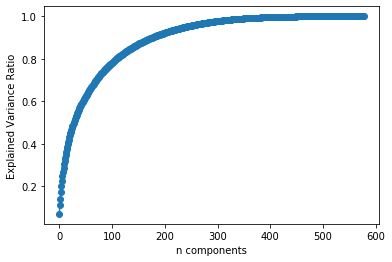

In [24]:
X = bgg.drop(columns=['title', 'full_game_url','rank','game_id','category','mechanic','family','avg_rating'])
cat_dummy = pd.get_dummies(csplit, prefix='cat')
X = pd.concat([X, cat_dummy], axis=1)
# X['play_time']=np.where((X.max_play_time - X.min_play_time) > 0, X.max_play_time - X.min_play_time, X.max_play_time)
# X.drop(columns=['max_play_time', 'min_play_time'], inplace=True)

# scaling
mm_scaler = MinMaxScaler()
mm_scaler.fit(X)
X = mm_scaler.transform(X)

#s_scaler = StandardScaler()
#s_scaler.fit(X)
#X = s_scaler.transform(X)

# fitting to data set 
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)

# plotting explained variance ratio
_ = plt.plot(features, pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
_ = plt.ylabel('Explained Variance Ratio')
_ = plt.xlabel('n components')

100 components keep approximately 80% of the explained variance.

In [25]:
pca = PCA(n_components=100)
pca.fit(X)
X_pca = pca.transform(X)

# create a DataFrame of the pca transformation
#X_pca_df = pd.DataFrame(X_pca)
#for n, col in enumerate(X_pca_df.columns, 1):
#    X_pca_df.rename(columns={col:'component_'+ str(n)},inplace=True)

### t-SNE & Agglomerative Clustering

In [ ]:
# In order to find meaningfully similar groups I found that the perplexity needed to be high
tsne = TSNE(perplexity=1500, learning_rate=500, random_state=23)
X_tsne = tsne.fit_transform(X_pca)

#xs = X_tsne[:,0]
#ys = X_tsne[:,1]

In [ ]:
agglom = AgglomerativeClustering(n_clusters=12, linkage='average')
agglom.fit(X_tsne)

In [ ]:
bgg_pca_tsne_agglom = pd.concat([bgg, pd.DataFrame(X_tsne, columns=['tsne_x','tsne_y'])], axis=1)
bgg_pca_tsne_agglom['cluster'] = agglom.labels_

In [26]:
#bgg_pca_tsne_agglom.to_csv('bgg_pca_tsne_agglom.csv')
bgg_pca_tsne_agglom = pd.read_csv('bgg_pca_tsne_agglom.csv', index_col=0)

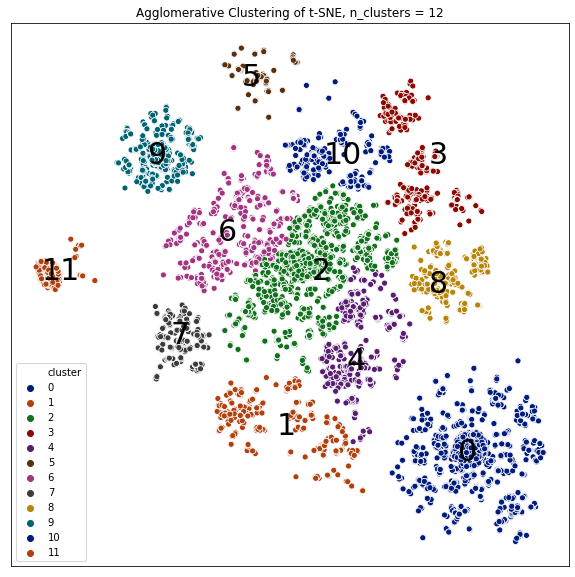

In [27]:
_ = plt.subplots(figsize=(10,10))
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette='dark')
_ = plt.title('Agglomerative Clustering of t-SNE, n_clusters = 12')
_ = plt.legend(loc='lower left')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
_ = plt.annotate(s='0', xy=(11.5,-14), size=30)
_ = plt.annotate(s='1', xy=(-4,-12), size=30)
_ = plt.annotate(s='2', xy=(-1,0), size=30)
_ = plt.annotate(s='3', xy=(9,9), size=30)
_ = plt.annotate(s='4', xy=(2,-7), size=30)
_ = plt.annotate(s='5', xy=(-7,15), size=30)
_ = plt.annotate(s='6', xy=(-9,3), size=30)
_ = plt.annotate(s='7', xy=(-13,-5), size=30)
_ = plt.annotate(s='8', xy=(9,-1), size=30)
_ = plt.annotate(s='9', xy=(-15,9), size=30)
_ = plt.annotate(s='10', xy=(0,9), size=30)
_ = plt.annotate(s='11', xy=(-24,0), size=30)

In [28]:
cluster_pivot = pd.pivot_table(bgg_pca_tsne_agglom, index='cluster', values=['geek_rating','weight','age','min_play_time','max_play_time'], aggfunc={'min','max','mean'})
cluster_pivot

age                 geek_rating                  max_play_time  \
          max       mean  min         max      mean    min           max   
cluster                                                                    
0        25.0  10.220927  3.0       8.219  5.673140  4.004        5000.0   
1        18.0   8.708920  1.0       8.573  5.705565  3.779        3498.0   
2        21.0  10.564502  3.0       8.472  5.712342  3.926       10000.0   
3        18.0   8.814456  2.0       7.929  5.687478  3.611         360.0   
4        21.0  10.251908  4.0       8.158  5.683220  4.311        1440.0   
5        16.0  11.910745  6.0       7.394  5.615204  5.351      120000.0   
6        18.0  11.505963  6.0       8.151  5.739936  5.283        6000.0   
7        18.0  11.042341  4.0       8.279  5.841101  4.299       12000.0   
8        18.0   7.266454  2.0       7.588  5.591051  4.486         360.0   
9        18.0   8.844137  3.0       7.729  5.636965  3.537         300.0   
10       18.0  11.098039  5.0       7.977  5.785728  4.740       10000.0   
11       18.0  12.045259  6.0       7.376  5.633414  5.409       60000.0   

                          min_play_time                   weight            \
               mean   min           max        mean   min    max      mean   
cluster                                                                      
0         41.738992   1.0         360.0   32.070180   1.0  4.395  1.746476   
1         67.315493   1.0         240.0   48.064977   1.0  4.562  1.890326   
2         67.421832   1.0        6000.0   54.383952   1.0  4.780  1.972245   
3         35.064829   1.0         180.0   27.624441   1.0  4.040  1.587154   
4         49.095725   1.0         300.0   39.189924   1.0  4.280  1.672178   
5        331.623917  10.0        3000.0  159.500000  10.0  5.000  2.843101   
6        125.000568  10.0        3600.0   93.681431   5.0  5.000  2.578756   
7        136.088418  20.0         960.0  103.616687  10.0  4.750  2.634301   
8         24.890234   1.0         360.0   21.386412   1.0  3.357  1.242012   
9         31.471668   1.0         180.0   26.870794   1.0  4.168  1.936517   
10       114.964245   2.0        1800.0   77.164706   1.0  4.330  2.344186   
11       462.172198   1.0       60000.0  315.191810   1.0  4.914  2.990319   

              
         min  
cluster       
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  
5        1.0  
6        1.0  
7        1.0  
8        1.0  
9        1.0  
10       1.0  
11       1.0

This chart shows some basic statistics of each cluster's age, Geek Rating, play times, and weight
age. Overall, mean Geek Ratings across clusters are fairly consistent. Cluster 11 stands out as having the highest mean age, min/max playtime and weight. This is followed closely by cluster 5. On the other hand, cluster 8 has the lowest means for all variables.

Below I've included heatmaps of the categories and mechanics that dominate each cluster and I've listed them here as well.

- Cluster 0: Card Games
- Cluster 1: Action, Adventure, Fantasy, Fighting & Miniatures
- Cluster 2: Adventure With Dice Rolling & Variable Player Powers
- Cluster 3: Animals, Bluffing & Card Games with Set Collection
- Cluster 4: Dice
- Cluster 5: Thematic Wargames
- Cluster 6: Sci-Fi: Fantasy, Fighting, Medieval, Miniatures, Science Fiction
- Cluster 7: Economic, Negotiation, Trains & Transportation
- Cluster 8: Children's Game & Action/Dexterity with Dice Rolling, Memory, & Pattern Recognition
- Cluster 9: Abstract Strategy With Pattern Building & Tile Placement
- Cluster 10: Ancient, Adventure, Card Games with Dice Rolling & Variable Player Powers
- Cluster 11: Simulation Wargames

The clusters dominated by the means of playing a game (clusters 0 and 4), dice and/or cards, are of interest. Of the 3,947 games in cluster 0 each one has the [Card Game](https://boardgamegeek.com/boardgamecategory/1002/card-game) category. Including games such as [Race for the Galaxy](https://boardgamegeek.com/boardgame/28143/race-galaxy) and the classic game of [Go Fish](https://boardgamegeek.com/boardgame/7682/go-fish). There are 5,504 total games in the data set with the Card Game category, so cluster 0 represents 72% of all Card Games. Likewise, cluster 4 contains 1,310 of the 1,617 games (81%) in the [Dice](https://boardgamegeek.com/boardgamecategory/1017/dice) category. While these are extreme examples, we can see that the clustering is not entirely predicated on labels.

The separation of clusters 5 and 11 are also of note. We saw that both these clusters have comparatively higher means for age, play times and weight. However, cluster 5 is dominated by more diverse categories such as [Nautical](https://boardgamegeek.com/boardgamecategory/1008/nautical), [Napoleonic](https://boardgamegeek.com/boardgamecategory/1051/napoleonic), [Science Fiction](https://boardgamegeek.com/boardgamecategory/1016/science-fiction), [Medieval](https://boardgamegeek.com/boardgamecategory/1035/medieval) where cluster 11 is primarily [World War II](https://boardgamegeek.com/boardgamecategory/1049/world-war-ii) games and, also notably, with a high proportion of the [Simulation](https://boardgamegeek.com/boardgamemechanic/2070/simulation) i.e. "games that attempt to model actual events or situations." Examples of World War II/Simulation games are [Combat Commander: Europe](https://boardgamegeek.com/boardgame/21050/combat-commander-europe) and [Conflict of Heroes: Awakening the Bear! – Russia 1941-42](https://boardgamegeek.com/boardgame/24800/conflict-heroes-awakening-bear-russia-1941-42) both involving "tactical infantry combat" in World War II scenarios.

Overall the dominant labels within each cluster can give you a good idea of what kind of game you might find in a given cluster. Except perhaps in cluster 3: [Animals](https://boardgamegeek.com/boardgamecategory/1089/animals), [Bluffing](https://boardgamegeek.com/boardgamecategory/1023/bluffing) & [Card Games](https://boardgamegeek.com/boardgamecategory/1002/card-game). While it does contain 85 games (6% of the cluster) with both Bluffing and Animals labels there is a distinction with 873 Animals games (of the 1,132 total) and 551 Bluffing games (of the 1,105 total) in the cluster. Maybe some of the Animal games belong in the neighboring cluster 8 with other Children's Games, but, on the other hand, the games you might think belong in the bluffing card game cluster, such as [Poker](https://boardgamegeek.com/boardgame/1115/poker) or [Blackjack](https://boardgamegeek.com/boardgame/10816/blackjack), are in cluster 0. Clearly there is something in this cluster causing distinction from the others. Returning to the descriptive statistics above we can see across the board that the means of cluster 3 are higher than cluster 8 which is stratifying these clusters.

In [29]:
# creating dummies
cat_dummy = pd.get_dummies(csplit, prefix='cat')
mech_dummy = pd.get_dummies(msplit, prefix='mech')

# game title and cluster dataframe
title_cluster = bgg_pca_tsne_agglom[['title','cluster']]

# merge title, cluster and category then melt into a long dataframe
title_cat = pd.merge(title_cluster,csplit,left_index=True, right_index=True)
title_cat_melt = pd.melt(title_cat, id_vars=('title', 'cluster'), value_name='category')
title_cat_melt.dropna(inplace=True)
title_cat_melt.drop(columns='variable',inplace=True)

# merge title, cluster and mechanic then melt into a long dataframe
title_mech = pd.merge(title_cluster,msplit,left_index=True, right_index=True)
title_mech_melt = pd.melt(title_mech, id_vars=('title', 'cluster'), value_name='mechanic')
title_mech_melt.dropna(inplace=True)
title_mech_melt.drop(columns='variable',inplace=True)

# merge both the long dataframes
cat_mech_merge = pd.merge(title_cat_melt, title_mech_melt, how='outer', on=['title','cluster'])

crosstab_list = []
# create a cross tab for each cluster and append to crosstab_list
for cluster in cat_mech_merge.cluster.sort_values().unique():
    df = cat_mech_merge[cat_mech_merge.cluster == cluster]
    crosstab = pd.crosstab(df.category, df.mechanic)
    crosstab_list.append(crosstab)

### Cluster 0 - Card Games

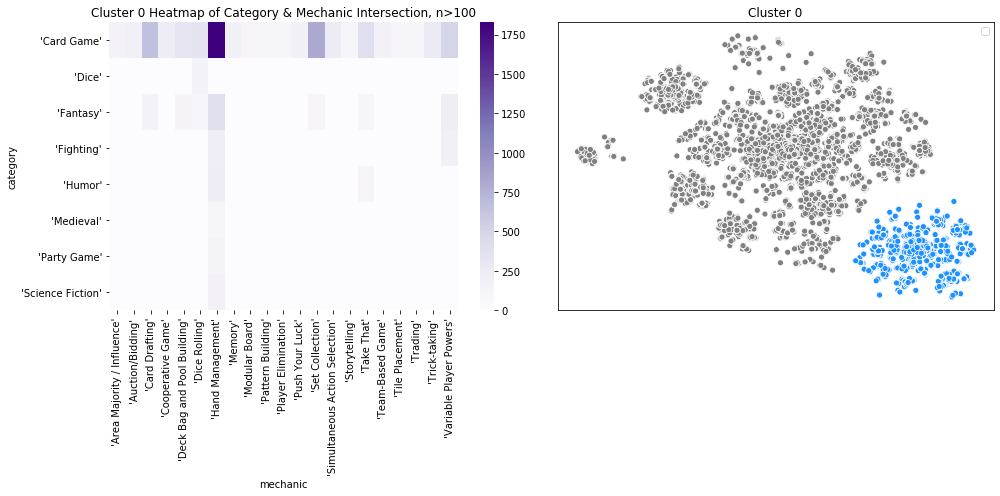

In [30]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[0].where(crosstab_list[0] > 100).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 0 Heatmap of Category & Mechanic Intersection, n>100')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'dodgerblue',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey',10:'grey',11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 0')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 1 - Action, Adventure, Fantasy, Fighting & Miniatures

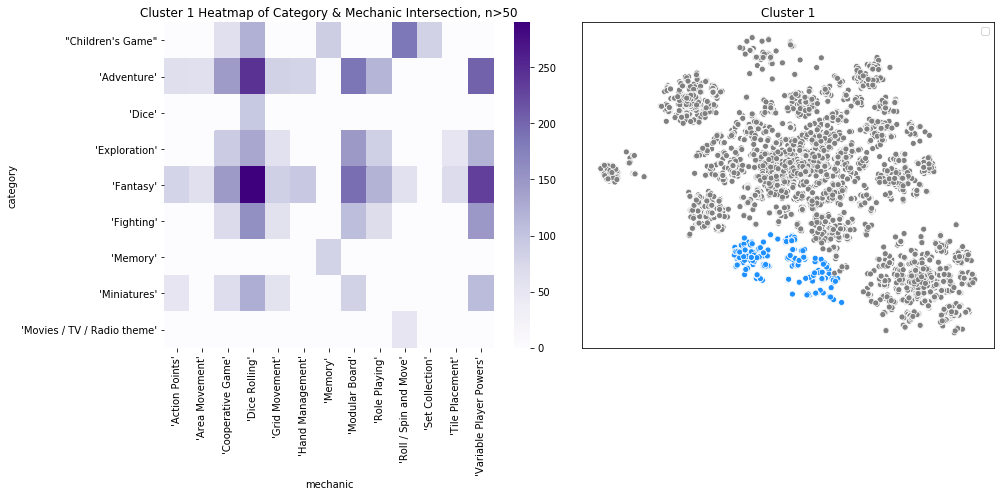

In [31]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[1].where(crosstab_list[1] > 50).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 1 Heatmap of Category & Mechanic Intersection, n>50')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'dodgerblue',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 1')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 2 - Adventure with Dice Rolling & Variable Player Powers

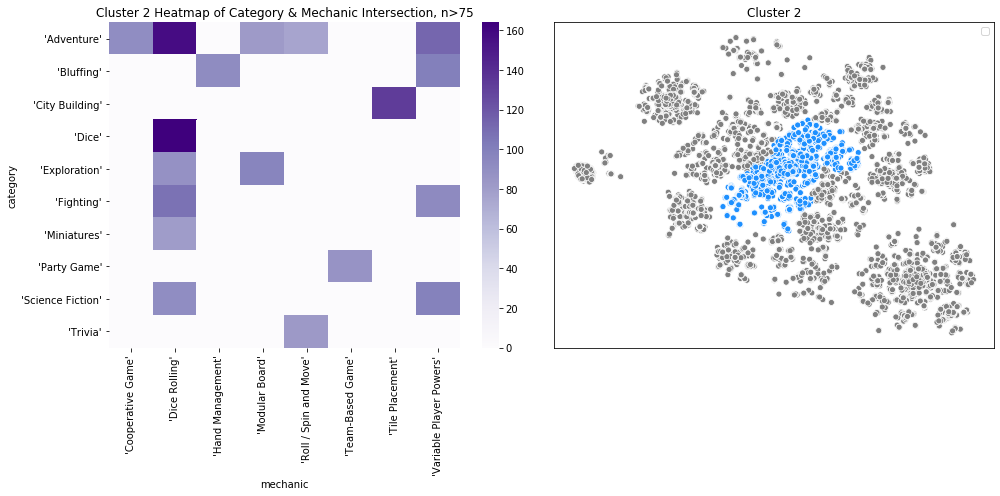

In [32]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[2].where(crosstab_list[2] > 75).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 2 Heatmap of Category & Mechanic Intersection, n>75')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'dodgerblue',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 2')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 3 - Animals, Bluffing, and Card Games

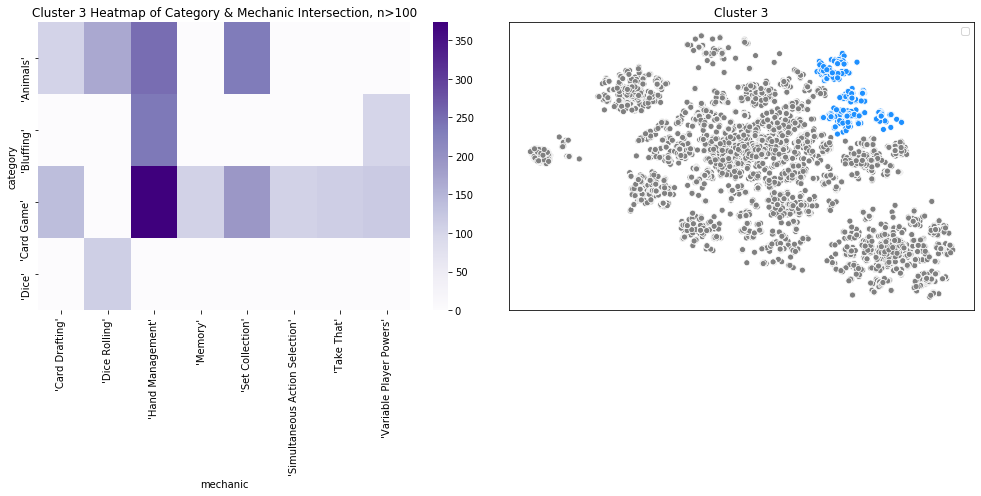

In [33]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[3].where(crosstab_list[3] > 100).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap="Purples")
_ = plt.title('Cluster 3 Heatmap of Category & Mechanic Intersection, n>100')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'dodgerblue',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 3')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 4 - Dice

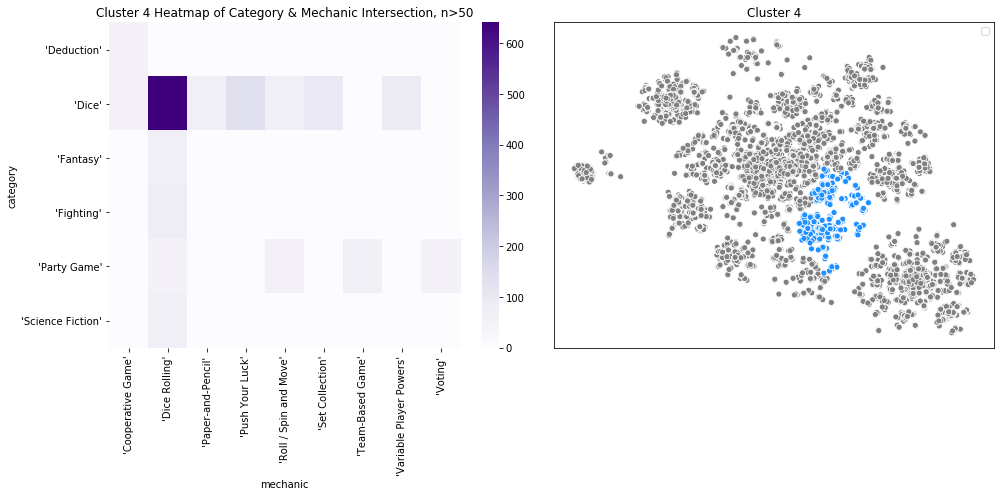

In [34]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[4].where(crosstab_list[4] > 50).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 4 Heatmap of Category & Mechanic Intersection, n>50')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'dodgerblue', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 4')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 5 - Thematic Wargames

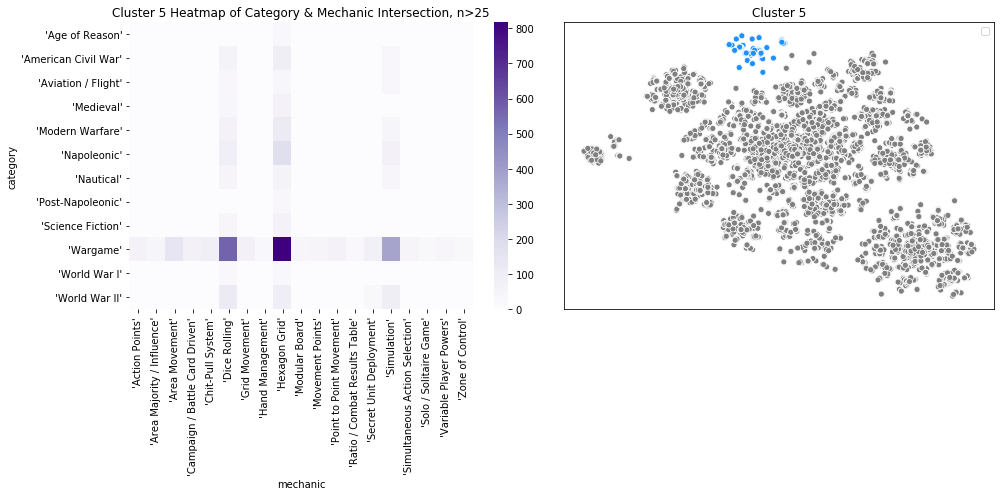

In [35]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[5].where(crosstab_list[5] > 25).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 5 Heatmap of Category & Mechanic Intersection, n>25')

_ = plt.subplot(1,2,2)

color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'dodgerblue', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 5')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 6 - Fantasy, Fighting, Medieval, Miniatures, Science Fiction, and Wargames

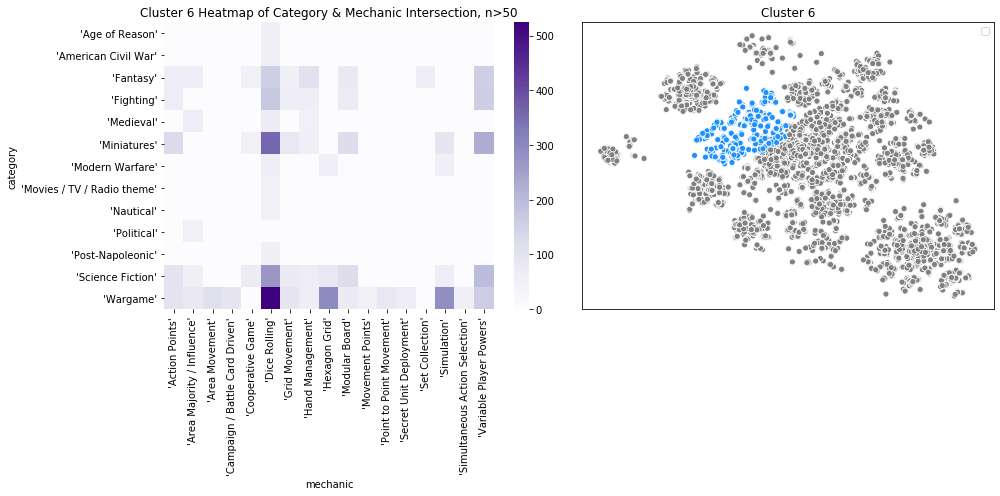

In [36]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[6].where(crosstab_list[6] > 50).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 6 Heatmap of Category & Mechanic Intersection, n>50')

_ = plt.subplot(1,2,2)

color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'dodgerblue',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 6')
_ = plt.legend('')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 7 - Economic, Negotiation, Trains & Transportation

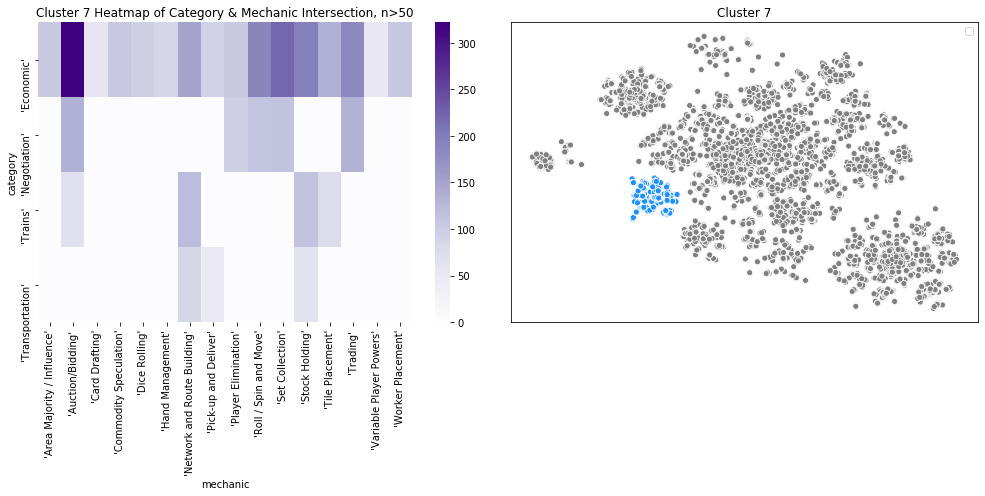

In [37]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[7].where(crosstab_list[7] > 50).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 7 Heatmap of Category & Mechanic Intersection, n>50')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'dodgerblue',8:'grey',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 7')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 8 - Children's Game and Action/Dexterity with Dice Rolling, Memory, and Pattern Recognition

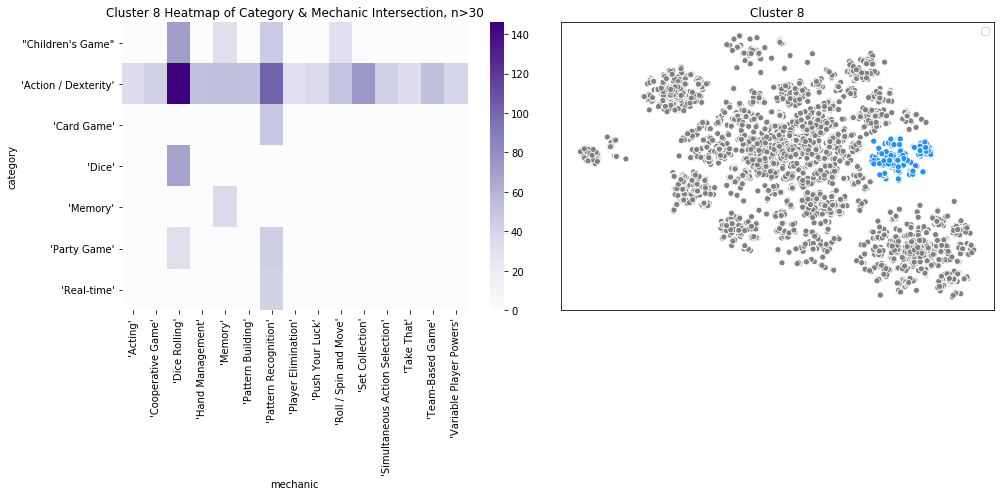

In [38]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[8].where(crosstab_list[8] > 30).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 8 Heatmap of Category & Mechanic Intersection, n>30')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'dodgerblue',9:'grey', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 8')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 9 - Abstract Strategy With Pattern Building & Tile Placement

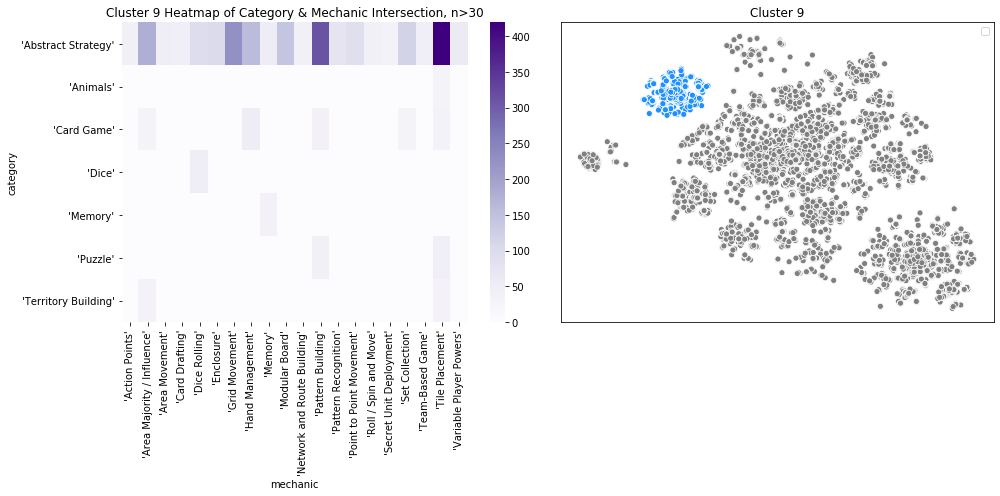

In [39]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[9].where(crosstab_list[9] > 30).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 9 Heatmap of Category & Mechanic Intersection, n>30')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'dodgerblue', 10:'grey', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 9')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 10 - Ancient, Adventure, Card Games with Dice Rolling & Variable Player Powers

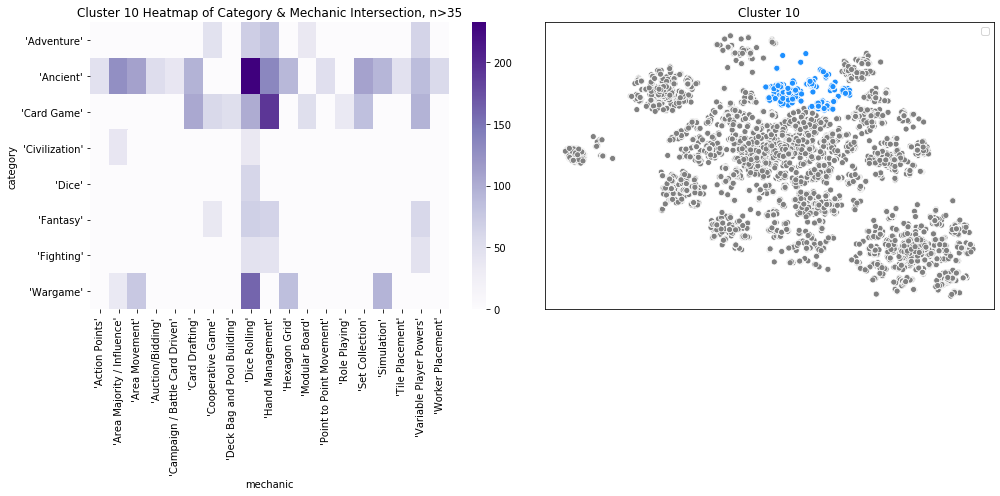

In [40]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[10].where(crosstab_list[10] > 35).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 10 Heatmap of Category & Mechanic Intersection, n>35')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'dodgerblue', 11:'grey'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 10')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()

### Cluster 11 - Simulation Wargames & World War II

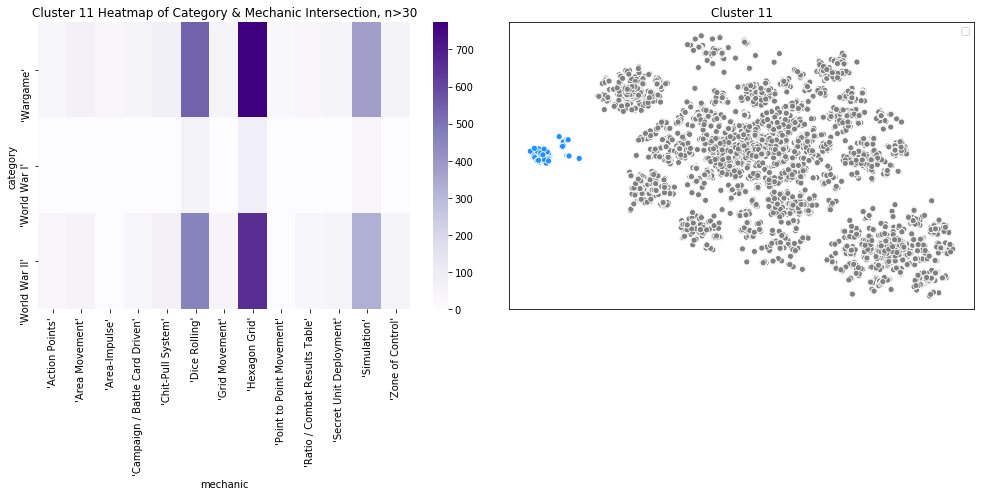

In [41]:
_ = plt.subplots(figsize=(14,7))
_ = plt.subplot(1,2,1)
df = crosstab_list[11].where(crosstab_list[11] > 30).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = sns.heatmap(df, cmap='Purples')
_ = plt.title('Cluster 11 Heatmap of Category & Mechanic Intersection, n>30')

_ = plt.subplot(1,2,2)
color_dict = dict({0:'grey',1:'grey',2:'grey',3: 'grey',4: 'grey', 
                   5:'grey', 6:'grey',7:'grey',8:'grey',9:'grey', 10:'grey', 11:'dodgerblue'})
_ = sns.scatterplot(data=bgg_pca_tsne_agglom, x='tsne_x',y='tsne_y', hue='cluster', palette=color_dict)
_ = plt.title('Cluster 11')
_ = plt.legend('')
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.tight_layout()